## 원시 EHR 데이터 전처리

## eICU 데이터 살펴보기

In [26]:
# Load libraries
import pandas as pd
import random
from datetime import datetime, timedelta

In [27]:
# Load CSVs
patient_df = pd.read_csv('/content/patient.csv', low_memory=False)
diagnosis_df = pd.read_csv('/content/diagnosis.csv', low_memory=False)

In [28]:
patient_df.head()

,patientunitstayid,patienthealthsystemstayid,gender,age,ethnicity,hospitalid,wardid,apacheadmissiondx,admissionheight,hospitaladmittime24,...,unitadmitsource,unitvisitnumber,unitstaytype,admissionweight,dischargeweight,unitdischargetime24,unitdischargeoffset,unitdischargelocation,unitdischargestatus,uniquepid
0,141168,128919,Female,70,Caucasian,59,91,"Rhythm disturbance (atrial, supraventricular)",152.4,15:54:00,...,Direct Admit,1,admit,84.3,85.8,03:50:00,3596,Death,Expired,002-34851
1,141178,128927,Female,52,Caucasian,60,83,NaN,162.6,08:56:00,...,Emergency Department,1,admit,54.4,54.4,09:18:00,8,Step-Down Unit (SDU),Alive,002-33870
2,141179,128927,Female,52,Caucasian,60,83,NaN,162.6,08:56:00,...,ICU to SDU,2,stepdown/other,NaN,60.4,19:20:00,2042,Home,Alive,002-33870
3,141194,128941,Male,68,Caucasian,73,92,"Sepsis, renal/UTI (including bladder)",180.3,18:18:40,...,Floor,1,admit,73.9,76.7,15:31:00,4813,Floor,Alive,002-5276
4,141196,128943,Male,71,Caucasian,67,109,NaN,162.6,20:21:00,...,ICU to SDU,2,stepdown/other,NaN,63.2,22:23:00,1463,Floor,Alive,002-37665


In [29]:
diagnosis_df.head()

,diagnosisid,patientunitstayid,activeupondischarge,diagnosisoffset,diagnosisstring,icd9code,diagnosispriority
0,4222318,141168,False,72,cardiovascular|chest pain / ASHD|coronary arte...,"414.00, I25.10",Other
1,3370568,141168,True,118,cardiovascular|ventricular disorders|cardiomyo...,NaN,Other
2,4160941,141168,False,72,pulmonary|disorders of the airways|COPD,"491.20, J44.9",Other
3,4103261,141168,True,118,pulmonary|disorders of the airways|COPD,"491.20, J44.9",Other
4,3545241,141168,True,118,cardiovascular|ventricular disorders|congestiv...,"428.0, I50.9",Other


## 전처리할 데이터 추출 (hospitalid 73)
Med-BERT의 입력 형식에 맞게 eICU 데이터를 아래와 같은 형태로 변환하여 준비하기
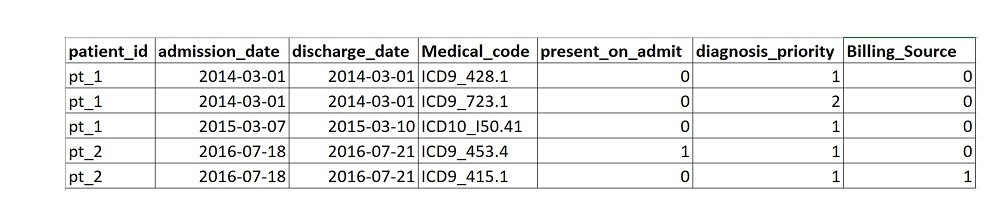

In [30]:
# Filter patients with hospitalid == 73
patient_filtered = patient_df[patient_df['hospitalid'] == 73]

# Merge with diagnosis data on 'patientunitstayid'
merged_df = pd.merge(diagnosis_df, patient_filtered, on='patientunitstayid', how='inner')

# Generate random admission and discharge dates
def generate_admission_and_discharge():
    base_date = datetime.strptime('2020-01-01', '%Y-%m-%d')
    admit_offset = random.randint(0, 365 * 2)  # up to 2 years from base
    admit_date = base_date + timedelta(days=admit_offset)
    stay_length = random.randint(1, 20)  # stay of 1–20 days
    discharge_date = admit_date + timedelta(days=stay_length)
    return admit_date.strftime('%Y-%m-%d'), discharge_date.strftime('%Y-%m-%d')

# Apply date generation
admission_discharge_dates = [generate_admission_and_discharge() for _ in range(len(merged_df))]
admission_dates, discharge_dates = zip(*admission_discharge_dates)

# Build final DataFrame
final_df = pd.DataFrame({
    'patient_id': merged_df['patientunitstayid'],
    'admission_date': admission_dates,
    'discharge_date': discharge_dates,
    'Medical_code': merged_df['icd9code'],
    'present_on_admit': merged_df['diagnosisoffset'].apply(lambda x: 1 if x < 0 else 0),
    'diagnosis_priority': merged_df['diagnosispriority'].map({'Primary': 1, 'Major': 2, 'Other': 3}),
    'Billing_Source': '0'  # or '0'
})

# Save to TSV
final_df.to_csv('/content/sample_data.tsv', sep='\t', index=False)



In [31]:
# 추출한 데이터 확인하기
df = pd.read_csv('sample_data.tsv', sep='\t')
df.head()

,patient_id,admission_date,discharge_date,Medical_code,present_on_admit,diagnosis_priority,Billing_Source
0,141284,2021-11-17,2021-11-22,"511.9, J91.8",0,3,0
1,141284,2021-04-08,2021-04-23,NaN,0,1,0
2,141284,2020-03-13,2020-03-16,NaN,0,1,0
3,141284,2020-08-07,2020-08-27,"486, J18.9",0,3,0
4,141284,2021-07-21,2021-07-29,"511.9, J91.8",0,3,0


In [32]:
# 열의 개수 확인하기
print("Number of rows:", len(df))

Number of rows: 42922


In [33]:
# 샘플링 수 정하기 위해 unique patient의 수 확인하기
df = pd.read_csv("sample_data.tsv", sep="\t")
print("Unique patients:", df["patient_id"].nunique())


Unique patients: 3800


## 데이터 전처리
다음과 같은 형태로 전처리:
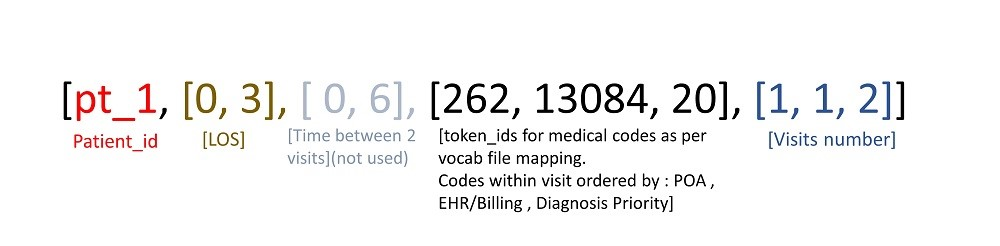

In [34]:
# Sample size 0: use entire dataset (데이터가 적으므로)
!python preprocess_pretrain_data.py sample_data.tsv NA output_prefix 0

 data file
Start Data Preprocessing !!!
processed 1000 pts
processed 2000 pts
processed 3000 pts
Splitting


## 전처리 결과 확인

In [35]:
import pickle

# Load ptencs (full patient encounter data)
with open("output_prefix.ptencs.train", "rb") as f:
    ptencs_train = pickle.load(f)

# Load bencs (BERT-friendly version)
with open("output_prefix.bencs.train", "rb") as f:
    bencs_train = pickle.load(f)

# Load types dictionary
with open("output_prefix.types", "rb") as f:
    types_dict = pickle.load(f)

In [36]:
# 환자 1명의 정보 보기
# [LOS (days), time_to_next (days), raw_diag_codes, tokenized_diag_ids]
import pprint

# Pretty-print one patient's full encounter list
pprint.pprint(ptencs_train[1])

[[[20, 0, ['729.81, M79.89'], [299]]]]


In [37]:
#
# [
#  patient_id,         # string or int: the patient’s unique ID
#  los_list,           # list of length-of-stay values for each visit
#  time_to_next_list,  # list of time (in days) to the next visit
#  token_seq,          # a flattened list of all diagnosis token IDs
#  visit_segments      # a list of same length as token_seq, marking which visit each token came from
#
# ]

# 출력 결과 확인
# Patient ID
# Visit 1: 1 day, Visit 2: 11 days, ... Visit 6: 20 days
# 퇴원으로부터 다음 입원까지 며칠이 지났는지
# ICD code를 정수로 매핑
# 각 ICD code가 몇 번 째 방문(예. Visit 1)에 해당하는지
pprint.pprint(bencs_train[1])

[239228,
 [1, 5, 13, 17, 9, 20],
 [109, 94, 82, 84, 203, 0],
 [27, 7, 299, 3, 3, 299],
 [1, 2, 3, 4, 5, 6]]


In [38]:
# ICD-9 코드를 integer 토큰으로 변환할 때 사용할 매핑
types_dict

{'empty_pad': 0,
 nan: 1,
 '486, J18.9': 2,
 '511.9, J91.8': 3,
 '799.02, J96.91': 4,
 '427.31, I48.0': 5,
 '518.82': 6,
 '585.6, N18.6': 7,
 '038.9, A41.9': 8,
 '441.9, I71.9': 9,
 '441.4, I71.4': 10,
 '441.00, I71.00': 11,
 '518.81, J96.00': 12,
 '441.02, I71.02': 13,
 '441.01, I71.01': 14,
 '786.09, J96.92': 15,
 '427.5, I46.9': 16,
 '344.1, G82.21': 17,
 '785.59, R57.1, R58': 18,
 '276.2, E87.2': 19,
 '584.9, N17.9': 20,
 '276.7, E87.5': 21,
 '428.1, I50.1': 22,
 '491.20, J44.9': 23,
 '401.9, I10': 24,
 '436, I67.8': 25,
 '458.9, I95.9': 26,
 '428.0, I50.9': 27,
 '414.00, I25.10': 28,
 '493.90, J45': 29,
 '790.6, R73.9': 30,
 '780.09, R41.82': 31,
 '451.2, I80.3': 32,
 '276.8, E87.6': 33,
 '348.31, G93.41': 34,
 '276.1, E87.0, E87.1': 35,
 '244.9, E03.9': 36,
 '785.52, R65.21': 37,
 '287.5, D69.6': 38,
 '575.0, K81.0': 39,
 '780.57, G47.33': 40,
 '31.1': 41,
 '595.9, N30.9': 42,
 '578.9, K92.2': 43,
 '585.9, N18.9': 44,
 '430, 331.3, G91.0, I60.9': 45,
 '197.0, C78.00': 46,
 '170.9

## BERT 입력용 Feature 생성

1. 환자 시퀀스 (raw data)를 읽어옴
2. 의료 코드를 vocab 파일을 사용해 토큰 ID로 변환
3. 토큰에 마스팅 적용
4. 시퀀스를 BERT 입력 형식으로 구성
5. 모든 데이터를 TFRecord 형식으로 저장 (TensorFlow에서 효율적으로 읽을 수 있는 바이너리 파일로 변환)

In [39]:
!python create_BERTpretrain_EHRfeatures.py \
  --input_file=/content/output_prefix.bencs.train \
  --output_file=/content/medbert_pretrain_input \
  --vocab_file=/content/output_prefix.types \
  --max_predictions_per_seq=1 \
  --max_seq_length=64

2025-06-15 08:33:49.327269: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-15 08:33:49.327322: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-15 08:33:49.328656: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-15 08:33:49.335717: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-15 08:33:50.304353: W tensorflow/compiler/tf2

## 실제 Pretraining 실행

1. medbert_pretrain_input 파일을 읽음
2. config.json에 따라 BERT 모델 생성
3. 마스킹된 EHR 코드 예측하는 방식으로 학습 시작
4. 일정 간격으로 평가 수행
5. 결과는 pretrain_output에 저장
** 데이터 사이즈를 고려하여 num_train_steps는 기존의 10,000에서 2000-3000으로 줄임

** 학습 데이터를 더 확보하려면 max_seq_lengths를 기존의 64에서 96으로 늘릴 것


In [40]:
import sys
sys.path.append("/content/modeling.py")
sys.path.append("/content/optimization.py")
sys.path.append("/content/config.json")
sys.path.append("/content/run_EHRpretraining_utils.py")

In [41]:
pip install tensorflow-addons

In [42]:
pip install tensorflow==2.15.0 keras==2.15.0 tensorflow-addons==0.21.0 --upgrade --quiet

In [44]:
## --do_train과 --do_eval 제거 (run_EHRpretraining.py를 tf 2.X 버전에 맞춰서 argparse 씀)
!python run_EHRpretraining.py \
  --input_file=/content/medbert_pretrain_input \
  --output_dir=/content/pretrain_output \
  --bert_config_file=config.json \
  --train_batch_size=8 \
  --max_seq_length=64 \
  --max_predictions_per_seq=1 \
  --num_train_steps=2000 \
  --num_warmup_steps=1000 \
  --learning_rate=5e-5

2025-06-15 08:49:49.537204: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-15 08:49:49.537262: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-15 08:49:49.539041: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-15 08:49:49.547071: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-15 08:49:50.513163: W tensorflow/compiler/tf2